In [33]:
from __future__ import print_function
import copy
# import cProfile, pstats, StringIO
import iminuit
# %load_ext ipycache
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
from multiprocessing import Pool
import numpy as np
import os
import pandas as pd
import pymp
import random
import scipy as sp
from scipy import optimize
from scipy import stats
import seaborn as sns
sns.set_style('darkgrid')
sns.set_context('paper')

In [6]:
import atm_c14_data
import c14_models
import c14_individuals_data

# reload(atm_c14_data)
# reload(c14_models)
# reload(c14_individuals_data);

In [7]:
def CI(M, p):
    value = M.values[p]
    lower = M.get_merrors()[p]['lower']
    upper = M.get_merrors()[p]['upper']
    return value + lower, value + upper

In [8]:
Klag = atm_c14_data.Klag
K = atm_c14_data.K
C = c14_models.C_scenario_A
C2 = c14_models.C_scenario_2POP

In [9]:
c14_patient_data = c14_individuals_data.c14_individual_data

In [10]:
hepatocyte_data = c14_individuals_data.c14_individual_data.query('type == "hepatocyte"')
hepatocyte_data.describe()

,Dbirth,Dcoll,d14C,mass
count,19.000000,19.000000,19.000000,19.0
mean,1964.021930,2015.605263,0.043114,1.0
std,20.059938,3.810909,0.021048,0.0
min,1932.583333,2004.833333,0.017700,1.0
25%,1946.166667,2016.458333,0.027331,1.0
50%,1964.000000,2016.750000,0.039600,1.0
75%,1981.250000,2017.125000,0.051000,1.0
max,1995.333333,2017.416667,0.090351,1.0


# Plot the data

## Atmospheric 14C

In [11]:
c14_data = atm_c14_data.c14_data

In [12]:
sns.set_context('paper')

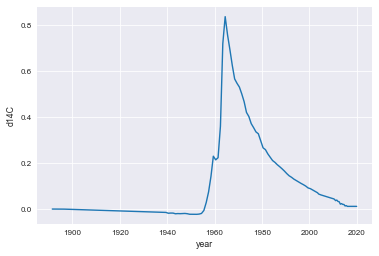

In [13]:
plt.figure()
plt.plot(c14_data['year'], c14_data['d14C'])
plt.xlabel('year')
plt.ylabel('d14C')
plt.show()

## Patient data

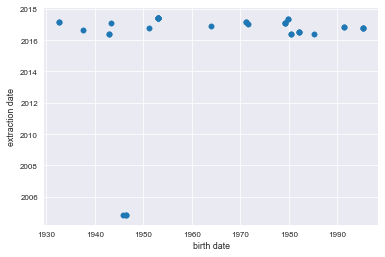

In [14]:
plt.figure()
plt.scatter(c14_patient_data['Dbirth'], c14_patient_data['Dcoll'])
plt.xlabel('birth date')
plt.ylabel('extraction date')
plt.show()

### Hepatocyte data

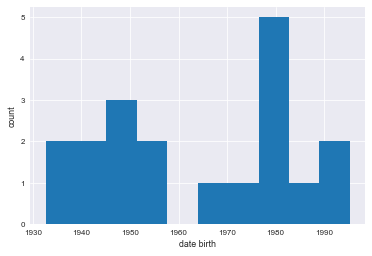

In [15]:
plt.figure()
plt.hist(hepatocyte_data['Dbirth'])
plt.xlabel('date birth')
plt.ylabel('count')
plt.show()

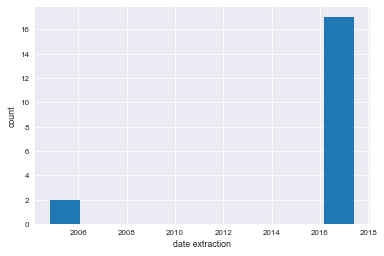

In [16]:
plt.figure()
plt.hist(hepatocyte_data['Dcoll'])
plt.xlabel('date extraction')
plt.ylabel('count')
plt.show()

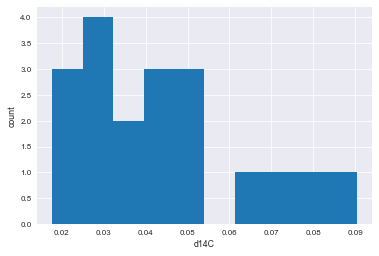

In [17]:
plt.figure()
plt.hist(hepatocyte_data['d14C'])
plt.xlabel('d14C')
plt.ylabel('count')
plt.show()

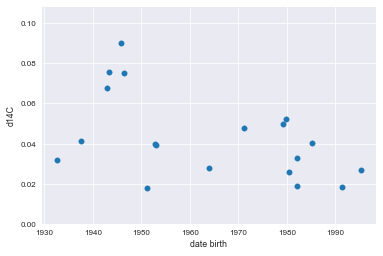

In [18]:
plt.figure()
plt.scatter(hepatocyte_data['Dbirth'], hepatocyte_data['d14C'])
plt.xlabel('date birth')
plt.ylabel('d14C')
plt.show()

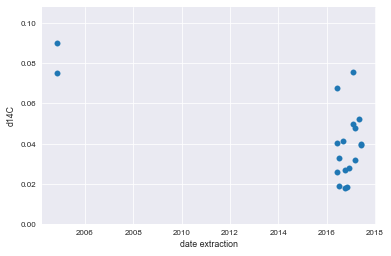

In [19]:
plt.figure()
plt.scatter(hepatocyte_data['Dcoll'], hepatocyte_data['d14C'])
plt.xlabel('date extraction')
plt.ylabel('d14C')
plt.show()

## Correlation atmospheric 14C at patient dates and 14C DNA concentration

Define helper function to get atmospheric 14C at given date

In [20]:
c14_atm = atm_c14_data.K

In [21]:
c14_atm(2000)

0.08829999999999995

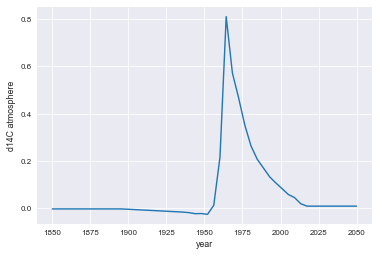

In [22]:
plt.figure()
time = sp.linspace(1850, 2050)
plt.plot(time, c14_atm(time))
plt.xlabel('year')
plt.ylabel('d14C atmosphere')
plt.show()

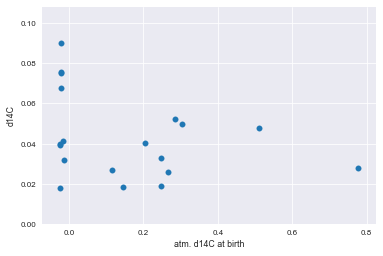

In [23]:
plt.scatter(c14_atm(hepatocyte_data['Dbirth']), hepatocyte_data['d14C'])
plt.xlabel('atm. d14C at birth')
plt.ylabel('d14C')
plt.show()

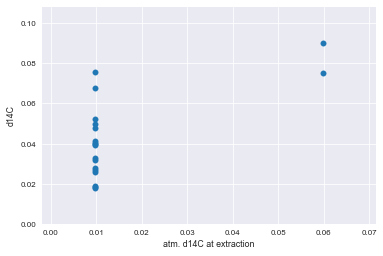

In [24]:
plt.scatter(c14_atm(hepatocyte_data['Dcoll']), 
            hepatocyte_data['d14C'])
plt.xlabel('atm. d14C at extraction')
plt.ylabel('d14C')
plt.show()

Only where atmospheric 14C data available:

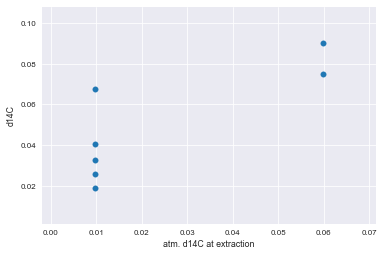

In [25]:
plot_data = hepatocyte_data.query('Dcoll < 2016.6')
plt.scatter(c14_atm(plot_data['Dcoll']), 
            plot_data['d14C'])
plt.xlabel('atm. d14C at extraction')
plt.ylabel('d14C')
plt.show()

## Scenario L

### The model

In [88]:
C_atm = atm_c14_data.Klag

def f(C, t):
    return 0.5 * (C + C_atm(t))

# def find_nearest_value(array,value):
#     return (np.abs(array-value)).argmin()

# find_nearest = np.vectorize(find_nearest_value, excluded=[0])

def find_nearest(CC,C):
    dC = (CC[1] - CC[0])/ (CC[-1] - CC[0]) 
    i = np.rint((C - CC[0])/ (CC[-1] - CC[0]) /dC)
    i = i.astype(int)
    return i

def k(t, C, CC):
    return find_nearest(CC, f(C, t))

def kCC(t, CC):
    return k(t, CC, CC)

def target_matrix(t, CC):
    T = np.zeros(2*[len(CC)])
    k = kCC(t, CC)
    for j, i in enumerate(k):
        T[i, j] = 1
    return T

def rate_matrix(t, CC):
    T = target_matrix(t, CC)
    A = T - np.eye(len(CC))
    return A

# def C(Dbirth, Dcoll, r, n=3, dt = 0.1):
#     C_min = C_atm(Dbirth)
#     C_max = C_atm(Dcoll)
    
#     CC = np.linspace(C_min, C_max, n)
    
#     N0 = np.zeros(n)
#     N0[find_nearest(CC, C_atm(0))] = 1
    
#     t = Dbirth
#     N = N0
#     while t<Dcoll:
#         A = rate_matrix(t, CC)
#         N += r * dt * A @ N
#         t += dt
    
#     C = np.average(CC, weights=N)
    
#     return C

def C_L1(Dbirth, Dcoll, r, n=10):
    C_min = atm_c14_data.c14_data['d14C'].min()
    C_max = atm_c14_data.c14_data['d14C'].max()
    
    CC = np.linspace(C_min, C_max, n)
    
    N0 = np.zeros(n)
    N0[find_nearest(CC, C_atm(0))] = 1
    
    def rhs(N, t0):
        A = rate_matrix(t0, CC)
        dNdt = r * A @ N
        return dNdt
    
    sol = sp.integrate.odeint(rhs, N0, (Dbirth, Dcoll), mxstep=int(1e5))
    N = sol[-1]
    C = np.average(CC, weights=N)
    return C

### constant sigma

In [89]:
sigma_estimate = hepatocyte_data['d14C'].std()
sigma_estimate

0.02104804968727416

In [97]:
def neg_loglike_L1(r, sigma):
    loglike = 0
    for i, dataset in hepatocyte_data.iterrows():
        Dbirth = dataset['Dbirth']
        Dcoll = dataset['Dcoll']
        Cexp = dataset['d14C']
        Cmodel = C_L1(Dbirth, Dcoll, r, n=5)
        
        loglike += sp.stats.norm.logpdf(Cexp, loc=Cmodel, scale=sigma)
    return -loglike

In [103]:
%%time
sp.optimize.minimize(lambda x: neg_loglike_L1(x[0], x[1]), [0.5, 0.02])

/usr/local/intel/intelpython3/lib/python3.6/site-packages/scipy/integrate/odepack.py:218: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/usr/local/intel/intelpython3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:876: RuntimeWarning: invalid value encountered in greater_equal
  return (self.a <= x) & (x <= self.b)
/usr/local/intel/intelpython3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:876: RuntimeWarning: invalid value encountered in less_equal
  return (self.a <= x) & (x <= self.b)


CPU times: user 3h 45min 42s, sys: 59.5 s, total: 3h 46min 41s
Wall time: 3h 45min 40s


      fun: nan
 hess_inv: array([[ 0.00259982, -0.03367901],
       [-0.03367901,  0.45710852]])
      jac: array([ nan,  nan])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 532
      nit: 6
     njev: 133
   status: 2
  success: False
        x: array([  115.79915125, -1455.75534347])

In [104]:
%load_ext line_profiler

In [105]:
%lprun -f neg_loglike_L1 sp.optimize.minimize(lambda x: neg_loglike_L1(x[0], x[1]), [0.5, 0.02])

/usr/local/intel/intelpython3/lib/python3.6/site-packages/scipy/integrate/odepack.py:218: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/usr/local/intel/intelpython3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:876: RuntimeWarning: invalid value encountered in greater_equal
  return (self.a <= x) & (x <= self.b)
/usr/local/intel/intelpython3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:876: RuntimeWarning: invalid value encountered in less_equal
  return (self.a <= x) & (x <= self.b)


In [102]:
%%time
M_L1 = iminuit.Minuit(neg_loglike_L1, errordef = 0.5,\
           r = 0.5, error_r = 1e-2, limit_r = (0.0, None), fix_r = False,\
           sigma = sigma_estimate, error_sigma = sigma_estimate / 10.0, limit_sigma = (0.0, None), fix_sigma = False,\
           print_level = 1)
M_L1.migrad();

FCN = -25.736196929605413 
 TOTAL NCALL = 83 
 NCALLS = 83 
 
 
 EDM = 5.551570810189741e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,r,0.0265743,0.0149228,0,0,0.0,,
2,sigma,0.0624365,0.0101233,0,0,0.0,,


CPU times: user 6.28 s, sys: 12 ms, total: 6.3 s
Wall time: 6.29 s


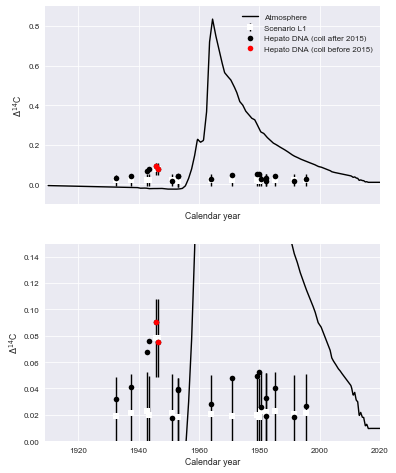

In [65]:
fig, axs = plt.subplots(2, 1, sharex = True, figsize = (6, 8))

time = sp.linspace(1910.0, 2020.0, 1000)


for ax in axs:
    ax.plot(time, K(time), label = 'Atmosphere', color = 'black')

    ax.errorbar(hepatocyte_data['Dbirth'], \
               sp.vectorize(C)(hepatocyte_data['Dbirth'], hepatocyte_data['Dcoll'], M_L1.values['r']), M_L1.values['sigma'],
               color = 'white', ecolor = 'black', label = 'Scenario L1', marker='s', ls = '')


    ax.errorbar(hepatocyte_data['Dbirth'], hepatocyte_data['d14C'], 
            marker = 'o', ls = 'None', color = 'black',
               label = 'Hepato DNA (coll after 2015)')
    ax.errorbar(hepatocyte_data.query('Dcoll < 2015')['Dbirth'], hepatocyte_data.query('Dcoll < 2015')['d14C'], 
               marker = 'o', ls = 'None', color = 'red', 
               label = 'Hepato DNA (coll before 2015)')


    ax.set_xlim((1909, 2020))
    ax.set_ylim(-0.1, 0.9)
    ax.set_xticks(sp.linspace(1910, 2010, 6), minor = 1)
    # ax.grid(which='both')
    

    ax.set_xlabel('Calendar year')
    ax.set_ylabel('$\Delta^{14}$C')

axs[0].legend()
axs[1].set_ylim(-0.0, 0.15)
    
plt.savefig('c14_predict_L1.svg')

plt.show()

## Scenario A

### Constant sigma

In [47]:
sigma_estimate = hepatocyte_data['d14C'].std()
sigma_estimate

0.02104804968727416

In [48]:
def neg_loglike_A(r, sigma):
    loglike = 0
    for i, dataset in hepatocyte_data.iterrows():
        Dbirth = dataset['Dbirth']
        Dcoll = dataset['Dcoll']
        Cexp = dataset['d14C']
        Cmodel = C(Dbirth, Dcoll, r)
        
        loglike += sp.stats.norm.logpdf(Cexp, loc=Cmodel, scale=sigma)
    return -loglike

In [49]:
M_A = iminuit.Minuit(neg_loglike_A, errordef = 0.5,\
           r = 0.0066, error_r = 1e-3, limit_r = (0.0, None), fix_r = False,\
           sigma = sigma_estimate, error_sigma = sigma_estimate / 10.0, limit_sigma = (0.0, None), fix_sigma = False,\
           print_level = 1)
M_A.migrad();

FCN = -50.67354170924234 
 TOTAL NCALL = 110 
 NCALLS = 110 
 
 
 EDM = 1.3227848621732788e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,r,0.200272,0.0347585,0,0,0.0,,
2,sigma,0.0168027,0.00272462,0,0,0.0,,


In [72]:
sns.set_context('paper', font_scale=1.1)

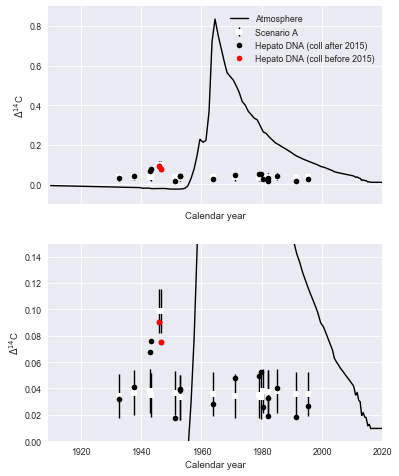

In [78]:
f, axs = plt.subplots(2, 1, sharex = True, figsize = (6, 8))

time = sp.linspace(1910.0, 2020.0, 1000)


for ax in axs:
    ax.plot(time, K(time), label = 'Atmosphere', color = 'black')

    ax.errorbar(hepatocyte_data['Dbirth'], \
               sp.vectorize(C)(hepatocyte_data['Dbirth'], hepatocyte_data['Dcoll'], M_A.values['r']), M_A.values['sigma'],
               color = 'white', ecolor = 'black', label = 'Scenario A', marker='s', ls = '')


    ax.errorbar(hepatocyte_data['Dbirth'], hepatocyte_data['d14C'], 
            marker = 'o', ls = 'None', color = 'black',
               label = 'Hepato DNA (coll after 2015)')
    ax.errorbar(hepatocyte_data.query('Dcoll < 2015')['Dbirth'], hepatocyte_data.query('Dcoll < 2015')['d14C'], 
               marker = 'o', ls = 'None', color = 'red', 
               label = 'Hepato DNA (coll before 2015)')


    ax.set_xlim((1909, 2020))
    ax.set_ylim(-0.1, 0.9)
    ax.set_xticks(sp.linspace(1910, 2010, 6), minor = 1)
    # ax.grid(which='both')
    

    ax.set_xlabel('Calendar year')
    ax.set_ylabel('$\Delta^{14}$C')

axs[0].legend()
axs[1].set_ylim(-0.0, 0.15)
    
plt.savefig('c14_predict_A.svg')

plt.show()

In [82]:
3./19

0.15789473684210525

In [9]:
M_A.minos(sigma = 1.92);

Error,-0.001436704145,0.00158800907363
Valid,True,True
At Limit,False,False
Max FCN,False,False
New Min,False,False


Error,-0.00861909641877,0.0117099986077
Valid,True,True
At Limit,False,False
Max FCN,False,False
New Min,False,False


In [10]:
CI(M_A, 'r')

(0.004108249373090833, 0.007132962591726963)

In [11]:
CI(M_A, 'sigma')

(0.04577181214223952, 0.0661009071687133)

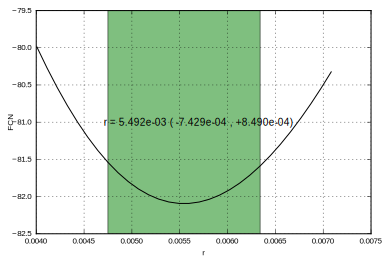

In [12]:
M_A.draw_mnprofile('r');

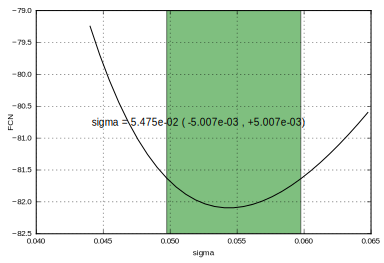

In [13]:
M_A.draw_mnprofile('sigma');

### Sigma dependent on mass of sample

In [14]:
def neg_loglike_A_mass(r, sigma_light, sigma_heavy):
    loglike = 0
    for i, dataset in hepatocyte_data.iterrows():
        Dbirth = dataset['Dbirth']
        Dcoll = dataset['Dcoll']
        Cexp = dataset['d14C']
        Cmodel = C(Dbirth, Dcoll, r)
        if dataset['mass'] < 10.0:
            sigma = sigma_light
        else:
            sigma = sigma_heavy
        
        
        loglike += sp.stats.norm.logpdf(Cexp, loc=Cmodel, scale=sigma)
    return -loglike

In [15]:
M_A_mass = iminuit.Minuit(neg_loglike_A_mass, errordef = 0.5,\
                          r = 0.0066, error_r = 1e-3, limit_r = (0.0, None), fix_r = False,\
                          sigma_light = sigma_estimate, error_sigma_light = sigma_estimate / 10.0,
                          limit_sigma_light = (0.0, None), fix_sigma_light = False,
                          sigma_heavy = sigma_estimate, error_sigma_heavy = sigma_estimate / 10.0,
                          limit_sigma_heavy = (0.0, None), fix_sigma_heavy = False,
                          print_level = 1)

In [16]:
M_A_mass.migrad();

FCN = -82.0959516923 
 TOTAL NCALL = 90 
 NCALLS = 90 
 
 
 EDM = 3.71665104387e-08 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,r,5.535547e-03,7.870723e-04,0.000000e+00,0.000000e+00,0.0,,
2,sigma_light,5.361449e-02,1.461596e-02,0.000000e+00,0.000000e+00,0.0,,
3,sigma_heavy,5.450396e-02,5.578983e-03,0.000000e+00,0.000000e+00,0.0,,


## 2POP

In [17]:
def neg_loglike_2POP(r, f, sigma):
    loglike = 0
    for i, dataset in hepatocyte_data.iterrows():
        Dbirth = dataset['Dbirth']
        Dcoll = dataset['Dcoll']
        Cexp = dataset['d14C']
        Cmodel = C2(Dbirth, Dcoll, r, f)
        
        loglike += sp.stats.norm.logpdf(Cexp, loc=Cmodel, scale=sigma)
    return -loglike

In [18]:
M_2POP = iminuit.Minuit(neg_loglike_2POP, errordef = 0.5,\
                   r = 0.12, error_r = 1e-3, limit_r = (0.0, None), fix_r = False,\
                   f=0.35, error_f=0.01, limit_f=(0.0, 1.0), fix_f = False,\
                   sigma = sigma_estimate, error_sigma = sigma_estimate / 10.0, limit_sigma = (0.0, None), fix_sigma = False,\
                   print_level = 1)

In [19]:
M_2POP.migrad();

FCN = -115.222983366 
 TOTAL NCALL = 121 
 NCALLS = 121 
 
 
 EDM = 3.97590302374e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,r,2.277187e-01,8.951309e-02,0.000000e+00,0.000000e+00,0.0,,
2,f,3.409061e-01,1.775861e-02,0.000000e+00,0.000000e+00,0.0,1.0,
3,sigma,2.978068e-02,2.839322e-03,0.000000e+00,0.000000e+00,0.0,,


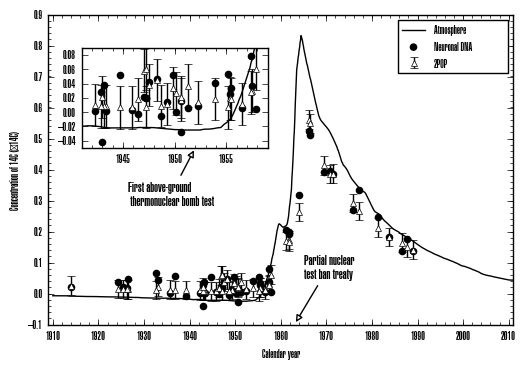

In [75]:
f, ax = plt.subplots(1, 1, figsize = (6, 4))

time = sp.linspace(1910.0, 2015.0, 1000)
ax.plot(time, K(time), label = 'Atmosphere                    ', color = 'black')
ax.scatter(hepatocyte_data['Dbirth'], hepatocyte_data['d14C'], color = 'black', label = 'Neuronal DNA            ')
ax.errorbar(hepatocyte_data['Dbirth'], \
           sp.vectorize(C2)(hepatocyte_data['Dbirth'], hepatocyte_data['Dcoll'], M_2POP.values['r'], M_2POP.values['f']),\
            M_2POP.values['sigma'],
           color = 'white', ecolor = 'black', label = '2POP', marker='^', ls = '', ms = 5)

ax.set_xlim((1909, 2011))
ax.set_ylim(-0.1, 0.9)
ax.set_xticks(sp.arange(1910, 2011, 10))
ax.set_xticks(sp.arange(1910, 2011, 2), minor = True)
ax.set_yticks(sp.arange(-0.1, 0.91, 0.1))
ax.set_yticks(sp.arange(-0.1, 0.91, 0.02), minor = True)
# ax.grid(which='both')
ax.legend(loc='best', numpoints = 1, scatterpoints = 1)

ax.set_xlabel('Calendar year')
ax.set_ylabel(u'Concentration of 14C (Δ14C)')

ax.annotate("Partial nuclear\ntest ban treaty", xy = (1963, ax.get_ylim()[0]), xytext = (1965, 0.05),
            arrowprops = dict(arrowstyle = '-|>', facecolor = 'white'))

axins = inset_axes(ax,
                   width="40%",  # width = 30% of parent_bbox
                   height=1.,  # height : 1 inch
                   loc=2, borderpad = 3)

axins.plot(time, K(time), label = 'Atmosphere                    ', color = 'black')
axins.scatter(hepatocyte_data['Dbirth'], hepatocyte_data['d14C'], color = 'black', label = 'Neuronal DNA            ')
axins.errorbar(hepatocyte_data['Dbirth'], \
           sp.vectorize(C2)(hepatocyte_data['Dbirth'], hepatocyte_data['Dcoll'], M_2POP.values['r'], M_2POP.values['f']),\
            M_2POP.values['sigma'],
           color = 'white', ecolor = 'black', label = '2POP', marker='^', ls = '', ms = 5)

axins.set_xlim(1941, 1959)
axins.set_ylim(-0.05, 0.09)
axins.set_xticks(sp.arange(1945, 1956, 5))
axins.set_xticks(sp.arange(1942, 1959, 1), minor=True)

axins.annotate("First above-ground\n thermonuclear bomb test", xy = (1952, axins.get_ylim()[0]), xytext = (1945.5, axins.get_ylim()[0] - 0.08),
            arrowprops = dict(arrowstyle = '-|>', facecolor = 'white'), horizontalalignment = 'left')

exportname = 'c14_predict_2POP'
plt.savefig('{}.svg'.format(exportname))
os.system('inkscape -D -z --file={0}.svg --export-pdf={0}.pdf'.format(exportname))

plt.show()

In [60]:
matplotlib.text.Text?

In [21]:
M_2POP.minos(sigma = 1.92);

Error,-0.0986781555538,0.0895130893041
Valid,True,False
At Limit,False,False
Max FCN,False,False
New Min,False,False


Error,-0.0348050653267,0.034814343781
Valid,True,True
At Limit,False,False
Max FCN,False,False
New Min,False,False


/home/fabian/anaconda2/envs/C14/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
        r = +nan
        f = +0.340917
    sigma = +0.025163

  if __name__ == '__main__':
/home/fabian/anaconda2/envs/C14/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
        r = -nan
        f = -nan
    sigma = +0.025163

  if __name__ == '__main__':


Error,-0.00471925098743,0.0064115387401
Valid,True,True
At Limit,False,False
Max FCN,False,False
New Min,False,False


In [22]:
CI(M_2POP, 'f')

(0.30610101795678873, 0.3757204270643956)

Calculate how much bigger Spalding's CI was:

In [23]:
Delta_Rost = CI(M_2POP, 'f')[1] - CI(M_2POP, 'f')[0]
Delta_Spalding = 0.63 - 0.12
Delta_Spalding/Delta_Rost

7.325543358343089

In [24]:
CI(M_2POP, 'sigma')

(0.02506143162720592, 0.0361922213547377)

/home/fabian/anaconda2/envs/C14/lib/python2.7/site-packages/ipykernel/__main__.py:1: UserWarning: Migrad fails to converge for f=0.332333
  if __name__ == '__main__':


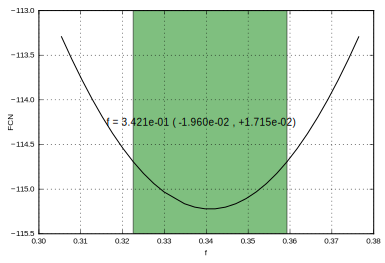

In [25]:
M_2POP.draw_mnprofile('f');

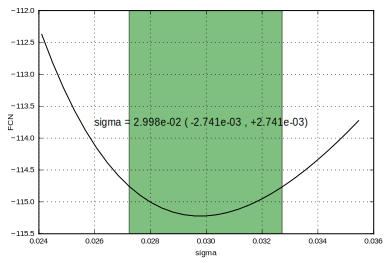

In [26]:
M_2POP.draw_mnprofile('sigma');

Manual profile likelihood for $r$ as `minos` didn't work.

In [27]:
%%cache rprofile.pkl rs neglogL
rs = sp.sort(sp.hstack((sp.linspace(0.1, 10, 50), M_2POP.values['r'], 0.15)))
f_initial = M_2POP.values['f']
sigma_initial = M_2POP.values['sigma']
def fit_fix_r(r):
    M_2POP = iminuit.Minuit(neg_loglike_2POP, errordef = 0.5,\
                   r = r, error_r = 1e-3, limit_r = (0.0, None), fix_r = True,\
                   f=0.35, error_f=0.01, limit_f=(0.0, 1.0), fix_f = False,\
                   sigma = sigma_estimate, error_sigma = sigma_estimate / 10.0, limit_sigma = (0.0, None), fix_sigma = False,\
                   print_level = 0)
    M_2POP.migrad()
    if M_2POP.migrad_ok():
        return M_2POP.fval
    else:
        return sp.nan

pool = Pool(processes=4) 

neglogL = sp.array(pool.map(fit_fix_r, rs))

[Skipped the cell's code and loaded variables neglogL, rs from file '/media/500G/fabian/work/hippocampus/C14/birth_death_implementation/C14_github/rprofile.pkl'.]


In [28]:
func = sp.interpolate.interp1d(rs, neglogL - neglogL.min() - 1.92) 

In [29]:
from scipy import optimize
rmin = sp.optimize.root(func, 0.1, method='lm')['x'].item()
rmax = sp.optimize.root(func, 2, method='lm')['x'].item()

print('r:')
print('{0:.2f} (95\% CI [{1:.2f}, {2:.2f}])'.format(M_2POP.values['r'], rmin, rmax))


r:
0.23 (95\% CI [0.14, 3.83])


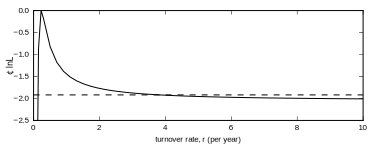

In [30]:
fig = plt.figure(figsize= (150 / 25.4, 50 / 25.4) )
plt.xlim(0, 10)
plt.ylim(-2.5, 0)

plt.xlabel('turnover rate, r (per year)')
plt.ylabel('$\Delta \ln L$')

# plt.grid()

plt.plot(rs, -(neglogL-M_2POP.fval), 'black')
plt.plot([0, 10], [-1.92, -1.92], 'k--')
# plt.plot([rmin, rmin], [-5, 0], 'k--')
# plt.plot([rmax, rmax], [-5, 0], 'k--')

exportname = 'rprofile'
plt.savefig('{}.svg'.format(exportname))
os.system('inkscape -D -z --file={0}.svg --export-pdf={0}.pdf'.format(exportname))

plt.show()

## 2POP mass

In [31]:
def neg_loglike_2POP_mass(r, f, sigma_light, sigma_heavy):
    loglike = 0
    for i, row in hepatocyte_data.iterrows():
        Dbirth = row['Dbirth']
        Dcoll = row['Dcoll']
        Cexp = row['d14C']
        Cmodel = C2(Dbirth, Dcoll, r, f)
        if row['mass'] < 10.0:
            sigma = sigma_light
        else:
            sigma = sigma_heavy
        
        loglike += sp.stats.norm.logpdf(Cexp, loc=Cmodel, scale=sigma)
    return -loglike

In [32]:
M_2POP_mass = iminuit.Minuit(neg_loglike_2POP_mass, errordef = 0.5,\
                   r = 0.12, error_r = 1e-3, limit_r = (0.0, None), fix_r = False,\
                   f=0.35, error_f=0.01, limit_f=(0.0, 1.0), fix_f = False,\
                   sigma_light = sigma_estimate*20, error_sigma_light = sigma_estimate / 10.0, limit_sigma_light = (0.0, None), fix_sigma_light = False,
                   sigma_heavy = sigma_estimate, error_sigma_heavy = sigma_estimate / 10.0, limit_sigma_heavy = (0.0, None), fix_sigma_heavy = False,\
                   print_level = 1)

In [33]:
M_2POP_mass.migrad();

FCN = -115.225987378 
 TOTAL NCALL = 256 
 NCALLS = 256 
 
 
 EDM = 5.4010511471e-08 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,r,2.286414e-01,8.480698e-02,0.000000e+00,0.000000e+00,0.0,,
2,f,3.407259e-01,1.792855e-02,0.000000e+00,0.000000e+00,0.0,1.0,
3,sigma_light,2.919448e-02,7.927086e-03,0.000000e+00,0.000000e+00,0.0,,
4,sigma_heavy,2.986507e-02,3.055224e-03,0.000000e+00,0.000000e+00,0.0,,


## Sample size estimation
Here, I create simulated data from the model to estimate the sample size (needed number of additional subjects) to find a upper limit for $r$. In the model simulation I'll use the estimated point estimates of the parameters as true parameters. I use scenario 2POP.
### Simulate the model

In [34]:
f_fit = M_2POP.values['f']
r_fit = M_2POP.values['r']
sigma_fit = M_2POP.values['sigma']

Let's first plot the model prediction for the expected difference in C-14 concentration when comparing the cases $r = r_{estimate}$ and $r = r_{max}$ and different birth and death times:

In [35]:
time_min, time_max = 1910, 2015
sampling = 1
birth_times, death_times = sp.mgrid[time_min:time_max:sampling, time_min:time_max:sampling]
C14_diff = sp.absolute(sp.vectorize(C2)(birth_times, death_times, r_fit, f_fit) - sp.vectorize(C2)(birth_times, death_times, rmax, f_fit))
C14_diff = sp.ma.masked_array(C14_diff, mask = sp.isnan(C14_diff))

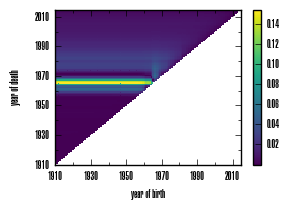

In [36]:
%config InlineBackend.figure_format = 'png'
fig, ax = plt.subplots(figsize = (3,2))
pcm = ax.pcolormesh(birth_times, death_times, C14_diff, cmap = 'viridis')
ax.set_xlabel('year of birth')
ax.set_ylabel('year of death', labelpad=10)
fig.colorbar(pcm)
ax.set_xlim(time_min, time_max)
ax.set_ylim(time_min, time_max)
ax.set_xticks(sp.arange(time_min, time_max, 20))
ax.set_xticks(sp.arange(time_min+10, time_max, 20), minor = True)
ax.set_yticks(sp.arange(time_min, time_max, 20))
ax.set_yticks(sp.arange(time_min+10, time_max, 20), minor = True)
# plt.contour(birth_times, death_times, C14_diff, [0.05], colors = 'red')

plt.show()

In [37]:
max_index = sp.unravel_index(C14_diff.argmax(), C14_diff.shape)
death_times[max_index]

1965

The biggest difference in C-14 is expected for subjects that died in 1965. 

### Creation of artifical subject data

#### Informative data

Based on the assumption that I my parameters are the true parameters I create artifical subject data by simulating the model. I'll choose subjects for which the expected difference in C-14 for the cases $r = r_{estimate}$ and $r = r_{max}$ is bigger than $0.05$.

/home/fabian/anaconda2/envs/C14/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in greater
  from ipykernel import kernelapp as app


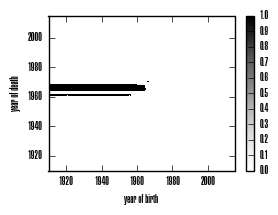

In [38]:
fig, ax = plt.subplots(figsize = (3,2))
pcm = ax.pcolormesh(birth_times, death_times, C14_diff > 0.05, cmap = 'Greys')
ax.set_xlabel('year of birth')
ax.set_ylabel('year of death')
fig.colorbar(pcm)
ax.set_xlim(time_min, time_max)
ax.set_ylim(time_min, time_max)

plt.show()

In [39]:
chosen_birth_times = birth_times[C14_diff > 0.05]
chosen_death_times = death_times[C14_diff > 0.05]
chosen_times = zip(chosen_birth_times, chosen_death_times)

/home/fabian/anaconda2/envs/C14/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':
/home/fabian/anaconda2/envs/C14/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in greater
  from ipykernel import kernelapp as app


In [40]:
%%cache profiles_r_2POP.pkl profile_r_2POP
profile_r_2POP = M_2POP.mnprofile('r', bound = [0.1, 1.5], subtract_min = True, bins = 60)

[Saved variables 'profile_r_2POP' to file '/media/500G/fabian/work/hippocampus/C14/birth_death_implementation/C14_github/profiles_r_2POP.pkl'.]


In [41]:
%%cache profiles.pkl profiles test_datasets
n = 5
test_datasets = {}
profiles = {}
for i in range(5):
    sp.random.seed(i)
    
    indices = sp.random.choice(len(chosen_birth_times), n)
    
#     sampled_birth_times = chosen_birth_times[indices]
#     sampled_death_times = chosen_death_times[indices]

    sampled_birth_times = sp.random.uniform(1910, 1960, n)
    sampled_death_times = sp.random.uniform(1961, 1970, n)
    d14C = sp.vectorize(C2)(sampled_birth_times, sampled_death_times, r_fit, f_fit) + sp.random.normal(0, sigma_fit, len(sampled_birth_times))
    
    new_data = pd.DataFrame.from_dict({'Dbirth': sampled_birth_times, 'Dcoll': sampled_death_times, 'd14C': d14C})
    
    test_datasets[i] = pd.concat([hepatocyte_data, new_data], ignore_index=True)

for i, data in test_datasets.iteritems():
    def neg_loglike_2POP_test(r, f, sigma):
        loglike = 0
        for i, dataset in data.iterrows():
            Dbirth = dataset['Dbirth']
            Dcoll = dataset['Dcoll']
            Cexp = dataset['d14C']
            Cmodel = C2(Dbirth, Dcoll, r, f)

            loglike += sp.stats.norm.logpdf(Cexp, loc=Cmodel, scale=sigma)
        return -loglike

    M_2POP_test = iminuit.Minuit(neg_loglike_2POP_test, errordef = 0.5,\
                   r = 0.2, error_r = 1e-3, limit_r = (0.0, None), fix_r = False,\
                   f= 0.3, error_f=0.01, limit_f=(0.0, 1.0), fix_f = False,\
                   sigma = 0.01, error_sigma = sigma_fit / 10.0, limit_sigma = (0.0, None), fix_sigma = False,\
                   print_level = 0)
    M_2POP_test.tol = 10.0
    M_2POP_test.migrad()
#     M_2POP_test.minos('r', sigma = 1.92)
    if M_2POP_test.migrad_ok():
        profiles[i] = M_2POP_test.mnprofile('r', bound = [0.1, 0.5], subtract_min = True, bins = 25);

[Saved variables 'profiles, test_datasets' to file '/media/500G/fabian/work/hippocampus/C14/birth_death_implementation/C14_github/profiles.pkl'.]


Plot the artificial test data

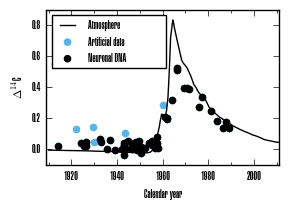

In [42]:
i = 1
artificial_data = test_datasets[i]

f, ax = plt.subplots(1, 1, figsize = (3, 2))

time = sp.linspace(1910.0, 2015.0, 1000)
ax.plot(time, K(time), label = 'Atmosphere                    ', color = 'black')
ax.scatter(artificial_data['Dbirth'], artificial_data['d14C'], color = colorcycle[i+1], label = 'Artificial data            ')
ax.scatter(hepatocyte_data['Dbirth'], hepatocyte_data['d14C'], color = 'black', label = 'Neuronal DNA                   ')
# ax.errorbar(artificial_data['Dbirth'], \
#            sp.vectorize(C2)(artificial_data['Dbirth'], artificial_data['Dcoll'], M_2POP.values['r'], M_2POP.values['f']),\
#             M_2POP.values['sigma'],
#            color = 'white', ecolor = 'black', label = '2POP', marker='^', ls = '', ms = 5)

ax.set_xlim((1909, 2011))
ax.set_ylim(-0.1, 0.9)
ax.set_xticks(sp.linspace(1910, 2010, 6), minor = 1)
# ax.grid(which='both')
ax.legend(loc='best', scatterpoints = 1)

ax.set_xlabel('Calendar year')
ax.set_ylabel('$\Delta^{14}$C')

# ax.annotate("First above-ground\nnuclear bomb test", xy = (1955, K(1955)), xytext = (1965, -0.08),
#             arrowprops = dict(arrowstyle = '-|>'))
# ax.annotate("Partial nuclear\ntest ban treaty", xy = (1963, K(1963)), xytext = (1967, 0.05),
#             arrowprops = dict(arrowstyle = '-|>'))


plt.show()

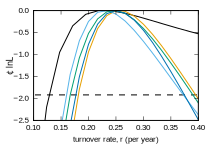

In [43]:
%config InlineBackend.figure_format = 'svg'

fig = plt.figure(figsize= (75 / 25.4, 50 / 25.4) )
plt.xlim(0.1, 0.4)
plt.ylim(-2.5, 0)

plt.xlabel('turnover rate, r (per year)')
plt.ylabel('$\Delta \ln L$')

# plt.grid()

plt.plot(profile_r_2POP[0], -sp.array(profile_r_2POP[1]), 'black')
plt.plot([0, 10], [-1.92, -1.92], 'k--')
# plt.plot([rmin, rmin], [-5, 0], 'k--')
# plt.plot([rmax, rmax], [-5, 0], 'k--')

for i, profile in profiles.iteritems():
    plt.plot(profile[0], -sp.array(profile[1]), color = colorcycle[i+1])


plt.show()

#### 'Recent' data
Now, I repeat the creation of artificial data as above, but for patients that died in recent years. I choose 2012. I assume they are born bewteen 1910 and 2010 with uniform random distribution.

In [44]:
len(hepatocyte_data)

55

In [45]:
%%cache profiles_recent.pkl profiles_recent test_datasets_recent
n = 100
test_datasets_recent = {}
profiles_recent = {}
for i in sp.arange(5)+1:
    sp.random.seed(i)
    
    sampled_birth_times = sp.random.uniform(1910, 2010, n)
    sampled_death_times = 2012 * sp.ones(n)
    d14C = sp.vectorize(C2)(sampled_birth_times, sampled_death_times, r_fit, f_fit) + sp.random.normal(0, sigma_fit, len(sampled_birth_times))
    
    new_data = pd.DataFrame.from_dict({'Dbirth': sampled_birth_times, 'Dcoll': sampled_death_times, 'd14C': d14C})
    
    test_datasets_recent[i] = pd.concat([hepatocyte_data, new_data], ignore_index=True)

for i, data in test_datasets_recent.iteritems():
    def neg_loglike_2POP_test(r, f, sigma):
        loglike = 0
        for i, dataset in data.iterrows():
            Dbirth = dataset['Dbirth']
            Dcoll = dataset['Dcoll']
            Cexp = dataset['d14C']
            Cmodel = C2(Dbirth, Dcoll, r, f)

            loglike += sp.stats.norm.logpdf(Cexp, loc=Cmodel, scale=sigma)
        return -loglike

    M_2POP_test = iminuit.Minuit(neg_loglike_2POP_test, errordef = 0.5,\
                   r = 0.2, error_r = 1e-3, limit_r = (0.0, None), fix_r = False,\
                   f= 0.3, error_f=0.01, limit_f=(0.0, 1.0), fix_f = False,\
                   sigma = 0.01, error_sigma = sigma_fit / 10.0, limit_sigma = (0.0, None), fix_sigma = False,\
                   print_level = 0)
    M_2POP_test.tol = 10.0
    M_2POP_test.migrad()
#     M_2POP_test.minos('r', sigma = 1.92)
    if M_2POP_test.migrad_ok():
        profiles_recent[i] = M_2POP_test.mnprofile('r', bound = [0.1, 1.5], subtract_min = True, bins = 60);

[Saved variables 'profiles_recent, test_datasets_recent' to file '/media/500G/fabian/work/hippocampus/C14/birth_death_implementation/C14_github/profiles_recent.pkl'.]


Plot the artificial test data

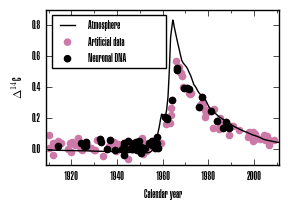

In [83]:
i = 1
artificial_data_recent = test_datasets_recent[i]

f, ax = plt.subplots(1, 1, figsize = (3, 2))

time = sp.linspace(1910.0, 2015.0, 1000)
ax.plot(time, K(time), label = 'Atmosphere                    ', color = 'black')
ax.scatter(artificial_data_recent['Dbirth'], artificial_data_recent['d14C'], color = colorcycle[7], label = 'Artificial data            ')
ax.scatter(hepatocyte_data['Dbirth'], hepatocyte_data['d14C'], color = 'black', label = 'Neuronal DNA                   ')
# ax.errorbar(artificial_data_recent['Dbirth'], \
#            sp.vectorize(C2)(artificial_data_recent['Dbirth'], artificial_data_recent['Dcoll'], M_2POP.values['r'], M_2POP.values['f']),\
#             M_2POP.values['sigma'],
#            color = 'white', ecolor = 'black', label = '2POP', marker='^', ls = '', ms = 5)

ax.set_xlim((1909, 2011))
ax.set_ylim(-0.1, 0.9)
ax.set_xticks(sp.linspace(1910, 2010, 6), minor = 1)
# ax.grid(which='both')
ax.legend(loc='best', scatterpoints = 1)

ax.set_xlabel('Calendar year')
ax.set_ylabel('$\Delta^{14}$C')

# ax.annotate("First above-ground\nnuclear bomb test", xy = (1955, K(1955)), xytext = (1965, -0.08),
#             arrowprops = dict(arrowstyle = '-|>'))
# ax.annotate("Partial nuclear\ntest ban treaty", xy = (1963, K(1963)), xytext = (1967, 0.05),
#             arrowprops = dict(arrowstyle = '-|>'))

plt.show()

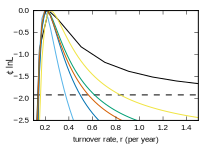

In [47]:
%config InlineBackend.figure_format = 'svg'

fig = plt.figure(figsize= (75 / 25.4, 50 / 25.4) )
plt.xlim(0.1, 1.5)
plt.ylim(-2.5, 0)

plt.xlabel('turnover rate, r (per year)')
plt.ylabel('$\Delta \ln L$')

# plt.grid()

# plt.plot(profile_r_2POP[0], -sp.array(profile_r_2POP[1]), 'black')
plt.plot(rs, -(neglogL-M_2POP.fval), 'black')
plt.plot([0, 10], [-1.92, -1.92], 'k--')
# plt.plot([rmin, rmin], [-5, 0], 'k--')
# plt.plot([rmax, rmax], [-5, 0], 'k--')

for i, profile in profiles_recent.iteritems():
    plt.plot(profile[0], -sp.array(profile[1]), color = colorcycle[i+1])

plt.show()

### Plot of artifial data results for thesis

/home/fabian/anaconda2/envs/C14/lib/python2.7/site-packages/ipykernel/__main__.py:53: DeprecationWarning: numpy boolean negative, the `-` operator, is deprecated, use the `~` operator or the logical_not function instead.


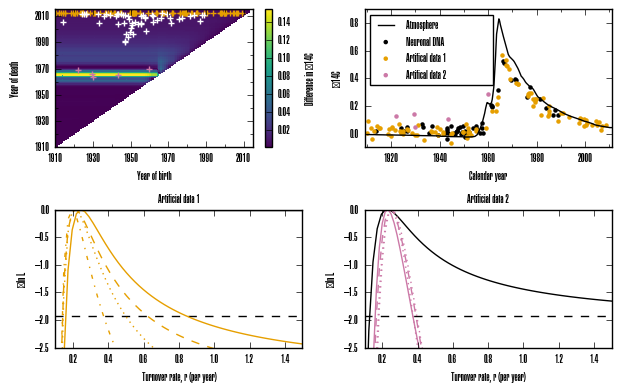

In [120]:
lineStyles = ['-', '--', '-.', ':']

new_artifical_data = artificial_data.loc[artificial_data.index.difference(hepatocyte_data.reset_index().index)]
new_artifical_data_recent = artificial_data_recent.loc[artificial_data_recent.index.difference(hepatocyte_data.reset_index().index)]

%config InlineBackend.figure_format = 'png'
fig, ax = plt.subplots(2, 2, figsize = (160/25.4,4))

pcm = ax[0,0].pcolormesh(birth_times, death_times, C14_diff, cmap = 'viridis', shading = 'gourad')
ax[0,0].scatter(new_artifical_data_recent['Dbirth'].values, new_artifical_data_recent['Dcoll'].values,
                marker = '+', c = colorcycle[1])
ax[0,0].scatter(new_artifical_data['Dbirth'].values, new_artifical_data['Dcoll'].values,
                marker = '+', c = colorcycle[7])
ax[0,0].scatter(hepatocyte_data['Dbirth'].values, hepatocyte_data['Dcoll'].values, marker = '+', c = 'white')
ax[0,0].set_xlabel('Year of birth')
ax[0,0].set_ylabel('Year of death', labelpad=10)
cb = fig.colorbar(pcm, ax=ax[0,0])
cb.set_label(u'Difference in Δ14C', labelpad = 10)
ax[0,0].set_xlim(time_min, time_max)
ax[0,0].set_ylim(time_min, time_max)
ax[0,0].set_xticks(sp.arange(time_min, time_max, 20))
ax[0,0].set_xticks(sp.arange(time_min+10, time_max, 20), minor = True)
ax[0,0].set_yticks(sp.arange(time_min, time_max, 20))
ax[0,0].set_yticks(sp.arange(time_min+10, time_max, 20), minor = True)
# ax[0,0].add_patch(patches.Rectangle((1910, 2012), 100, 1, fill=False, color=colorcycle[1]))
# ax[0,0].add_patch(patches.Rectangle((1910, 1961), 50, 9, fill=False, color=colorcycle[2]))


artificial_data = test_datasets[1]
msize = 5
time = sp.linspace(1910.0, 2015.0, 1000)
ax[0,1].plot(time, K(time), label = 'Atmosphere                    ', color = 'black')
ax[0,1].scatter(hepatocyte_data['Dbirth'], hepatocyte_data['d14C'], 
                color = 'black', label = 'Neuronal DNA                        ', s = msize)
ax[0,1].scatter(new_artifical_data_recent['Dbirth'], new_artifical_data_recent['d14C'], 
                color = colorcycle[1], label = 'Artifical data 1', s = msize)
ax[0,1].scatter(new_artifical_data['Dbirth'], new_artifical_data['d14C'], 
                color = colorcycle[7], label = 'Artifical data 2     ', s = msize)


ax[0,1].set_xlim((1909, 2011))
ax[0,1].set_ylim(-0.1, 0.9)
ax[0,1].set_xticks(sp.linspace(1910, 2010, 6), minor = 1)
ax[0,1].legend(loc='upper left', scatterpoints = 1)
ax[0,1].set_xlabel('Calendar year')
ax[0,1].set_ylabel(u'Δ14C')

ax[1,0].set_title('Artificial data 1', fontsize = 8)
ax[1,0].set_xlim(0.1, 1.5)
ax[1,0].set_ylim(-2.5, 0)
ax[1,0].set_xlabel('Turnover rate, r (per year)')
ax[1,0].set_ylabel(u'Δln L')
ax[1,0].plot(profile_r_2POP[0], -sp.array(profile_r_2POP[-1]), 'black')
# ax[1,0].plot(rs, -(neglogL-M_2POP.fval), 'black')
ax[1,0].plot([0, 10], [-1.92, -1.92], 'k--')
for i, profile in profiles_recent.iteritems():
    ax[1,0].plot(profile[0], -sp.array(profile[1]), color = colorcycle[1], ls = lineStyles[len(profile) - i])
    if i == len(lineStyles):
        break
    
ax[1,1].set_title('Artificial data 2', fontsize = 8)
ax[1,1].set_xlim(0.1, 1.5)
ax[1,1].set_ylim(-2.5, 0)
ax[1,1].set_xlabel('Turnover rate, r (per year)')
ax[1,1].set_ylabel(u'Δln L')
ax[1,1].plot(profile_r_2POP[0], -sp.array(profile_r_2POP[1]), 'black')
# ax[1,1].plot(rs, -(neglogL-M_2POP.fval), 'black')
ax[1,1].plot([0, 10], [-1.92, -1.92], 'k--')
for i, profile in profiles.iteritems():
    ax[1,1].plot(profile[0], -sp.array(profile[1]), color = colorcycle[7], ls = lineStyles[i-1])
    if i == len(lineStyles):
        break

plt.tight_layout()

exportname = 'c14_add_data'
plt.savefig('{}.svg'.format(exportname))
os.system('inkscape -D -z --file={0}.svg --export-pdf={0}.pdf'.format(exportname))


plt.show()